# Sentiment Analysis of IMDB Movie Reviews

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

import re,string
from wordcloud import WordCloud,STOPWORDS

In [2]:
data = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
#Class Distrubution
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Change Target variable

In [5]:
## 0 as Negative and 1 as Positive
data.sentiment = data.sentiment.apply(lambda x: 0 if x=='negative' else 1)

<h1>Feature Engineering</h1>

### Indirect features:
- count of sentences
- count of title words
- count of stop words
- count of words
- count/percentage of unique words
- count/percentage of punctuations

In [6]:
## Indirect features
eng_stopwords = set(stopwords.words("english"))

data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

data['count_word'] = data["review"].apply(lambda x: len(str(x).split()))
data['count_unique_word'] = data["review"].apply(lambda x: len(set(str(x).split())))
data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
data['word_unique_percent'] = data['count_unique_word'] * 100 / data['count_word']
data['punct_percent'] = data['count_punctuations'] * 100 / data['count_word']


In [7]:
## Reordering the columns 
data = data[['review', 'count_words_title', 'count_stopwords',
             'count_word', 'count_unique_word', 'count_punctuations',
             'word_unique_percent', 'punct_percent','sentiment']]
data.head()

,review,count_words_title,count_stopwords,count_word,count_unique_word,count_punctuations,word_unique_percent,punct_percent,sentiment
0,One of the other reviewers has mentioned that ...,36,133,307,208,78,67.752443,25.407166,1
1,A wonderful little production. <br /><br />The...,12,66,162,114,44,70.370370,27.160494,1
2,I thought this was a wonderful way to spend ti...,20,76,166,121,40,72.891566,24.096386,1
3,Basically there's a family where a little boy ...,13,62,138,96,42,69.565217,30.434783,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",31,96,230,152,56,66.086957,24.347826,1


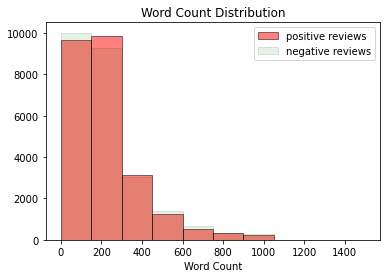

In [8]:
plt.hist(data[data['sentiment']==0]['count_word'], range=(0,1500), color='red', edgecolor='black', 
         label='positive reviews', alpha=0.5)
plt.hist(data[data['sentiment']==1]['count_word'], range=(0,1500), color='green', edgecolor='black', 
         label='negative reviews', alpha=0.1)

plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.legend()
plt.show()

## Text Preprocessing of Reviews

<b> In machine learning task, cleaning or pre-processing the data is as important as model building if not more. And when it comes to unstructured data like text, this process is of most importance. IMDB reviews are posted by users manually, so we observe high usage of contractions and chat words in it. Also, some reviews are collected from other sites, so we also observe usage of many HTML tags in dataset.</b>

**a. Clean Contractions or Chat Words:**
As this is manually entered reviews, people do use a lot of abbreviated words in chat and so it is important for us to expand all such chat words and contractions used. I’ve used list of slangs and contractions from repo.

**b. Lower Casing** Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way. This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.

**c. Removal Of Stop Words**
Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis. These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language is,

**d. Lemmatization**
Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language. As a result, this one is generally slower than stemming process. I’m using standard WordNetLemmatizer for work.

**e. Removal Of Urls & HTML Tags:**
We found large usage of HTML tags in dataset. To make sense of dataset, such tags to be removed.

**f. Removal Of Punctuations** In this process, we remove the punctuations (!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~) from the text data. This is a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way. Note of caution- This process has to be performed after removal of HTML tags else some standard tags of HTML will partially get removed in this process and afterwards HTML removal process will not give suitable results.

In [9]:
# Removing all punctuations from Text
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
PUNCT_TO_REMOVE = string.punctuation # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
eng_stopwords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in eng_stopwords])

def word_replace(text):
    return text.replace('<br />','')

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def preprocess(text):
    text = clean_contractions(text, mapping)
    text = text.lower()
    text = word_replace(text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = lemmatize_words(text)
    
    return text

In [10]:
data["reviews_preprocessed"]=data["review"].apply(lambda text: preprocess(text))
data.head()

,review,count_words_title,count_stopwords,count_word,count_unique_word,count_punctuations,word_unique_percent,punct_percent,sentiment,reviews_preprocessed
0,One of the other reviewers has mentioned that ...,36,133,307,208,78,67.752443,25.407166,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,12,66,162,114,44,70.370370,27.160494,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,20,76,166,121,40,72.891566,24.096386,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,13,62,138,96,42,69.565217,30.434783,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",31,96,230,152,56,66.086957,24.347826,1,petter matteis love time money visually stunni...


# Word Cloud

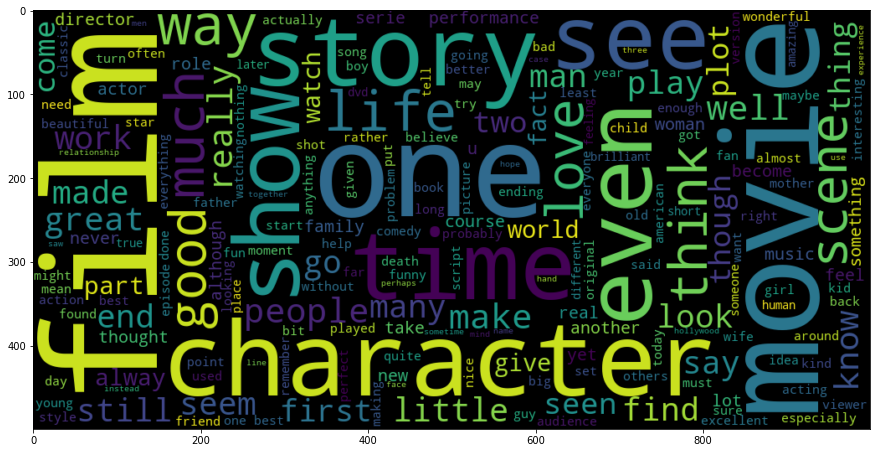

In [11]:
# Positive Reviews.
plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=200, width=1000, height=500, stopwords=STOPWORDS).generate(" ".join(data[data.sentiment==1].reviews_preprocessed))
plt.imshow(wc, interpolation='bilinear')

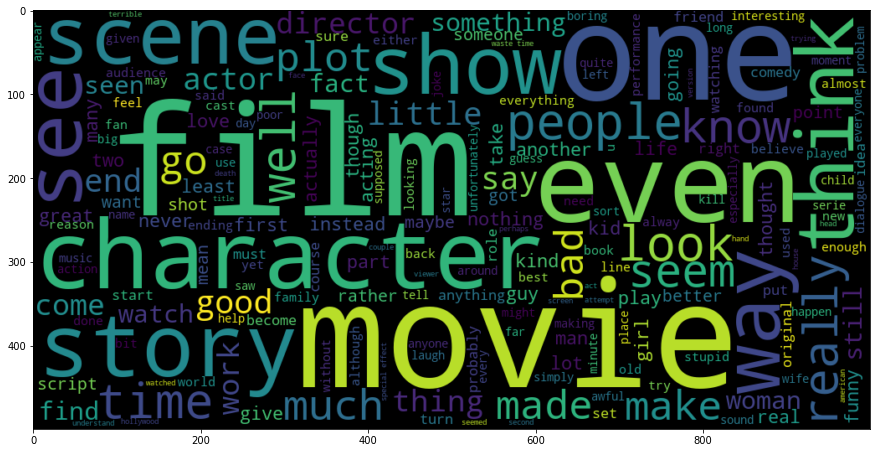

In [12]:
# Negative Reviews.
plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=200, width=1000, height=500, stopwords=STOPWORDS).generate(" ".join(data[data.sentiment==0].reviews_preprocessed))
plt.imshow(wc, interpolation='bilinear')

- From these word clouds, we are not able to judge any starling differences in both the sentiments by looking at words. We don’t see usage of extreme negative connotation or abusive language used while writing negative reviews.

### Utility Function

In [13]:
def metrics(model, x , y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print("\nAccuracy: ", round(acc,3))
    print("\nF1 Score: ", round(f1,3))
    
    cm=confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=[0,1], fmt='d', annot_kws={"fontsize":19})
    plt.xlabel("Predicted", fontsize=16)
    plt.ylabel("Actual", fontsize=16)
    plt.show()

# Model based on Indirect Features

In [14]:
X = data[['count_words_title', 'count_stopwords',
        'count_word', 'count_unique_word', 'count_punctuations',
        'word_unique_percent', 'punct_percent']]

y = data['sentiment']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(40000, 7), (10000, 7), (40000,), (10000,)]


Accuracy:  0.586

F1 Score:  0.575


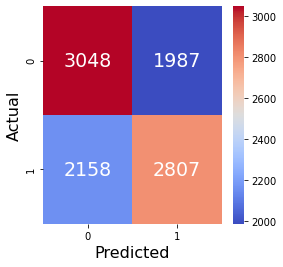

In [16]:
linear_svc = LinearSVC(penalty='l2', dual=False)
linear_svc.fit(X_train, y_train)
metrics(linear_svc, X_test, y_test)

- As expected, this model is giving us poor accuracy of 58% as we depicted in EDA. Indirect features have very similar trends and patterns across both the classes, we have seen in EDA portion.

## N-gram Analysis
- The order that words are used in text is not random. In English, for example, you can say "the red apple" but not "apple red the". The general idea is that you can look at each pair (or double, triple etc.) of words that occur next to each other. In a sufficently-large corpus, you're likely to see "the red" and "red apple" several times, but less likely to see "apple red" and "red the". This is useful to know if, for example, you're trying to figure out what someone is more likely to say to help decide between possible output for an automatic speech recognition system. These co-occuring words are known as "n-grams", where "n" is a number saying how long a string of words you considered.

In [17]:
#dtype: string
texts = ' '.join(data['reviews_preprocessed'])
texts_to_list = texts.split(" ")

In [18]:
def draw_n_gram(texts_to_list, i):
    n_gram = (pd.Series(nltk.ngrams(texts_to_list, i)).value_counts())[:11]
    n_gram_df = pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head(10))
    plt.figure(figsize=(10,5))
    return sns.barplot(x='count', y='word', data=n_gram_df, palette="Blues_d")

## Unigram Analysis

           word  count
0      (movie,)  98938
1       (film,)  89753
2        (one,)  52648
3       (like,)  39780
4      (would,)  30291
5       (time,)  29353
6       (good,)  28596
7  (character,)  27569
8        (get,)  24432
9       (even,)  24281


<AxesSubplot:xlabel='count', ylabel='word'>

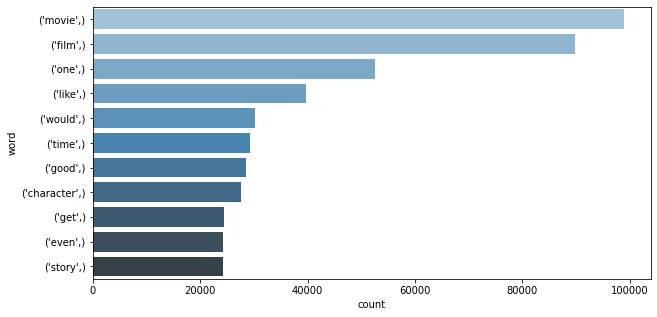

In [19]:
draw_n_gram(texts_to_list, 1)

## Bigram Analysis

                word  count
0       (look, like)   2874
1       (ever, seen)   2534
2  (special, effect)   2198
3      (movie, ever)   1937
4  (main, character)   1875
5     (even, though)   1868
6        (one, best)   1827
7      (movie, like)   1716
8        (year, old)   1633
9    (horror, movie)   1490


<AxesSubplot:xlabel='count', ylabel='word'>

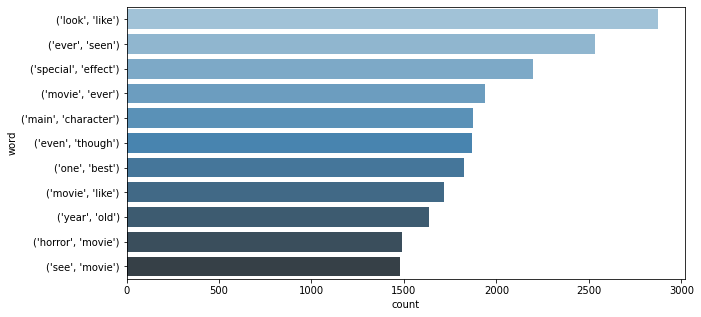

In [20]:
draw_n_gram(texts_to_list, 2)

## Trigram Analysis

                   word  count
0   (movie, ever, seen)    828
1  (worst, movie, ever)    731
2    (film, ever, seen)    413
3   (worst, film, ever)    344
4   (movie, ever, made)    337
5   (one, worst, movie)    315
6    (film, ever, made)    293
7     (new, york, city)    263
8      (world, war, ii)    209
9   (movie, like, this)    191


<AxesSubplot:xlabel='count', ylabel='word'>

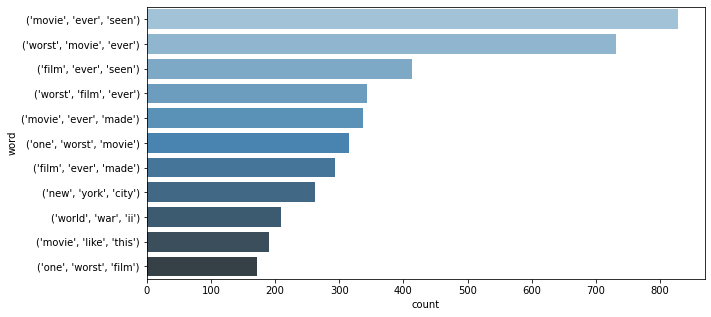

In [21]:
draw_n_gram(texts_to_list, 3)

## Quadgram Analysis

                                word  count
0         (worst, movie, ever, seen)    403
1          (one, worst, movie, ever)    239
2          (worst, film, ever, seen)    175
3           (one, worst, film, ever)    119
4         (worst, movie, ever, made)    118
5          (worst, film, ever, made)     78
6            (plan, 9, outer, space)     76
7  (mystery, science, theater, 3000)     74
8          (movie, seen, long, time)     58
9           (one, best, movie, ever)     57


<AxesSubplot:xlabel='count', ylabel='word'>

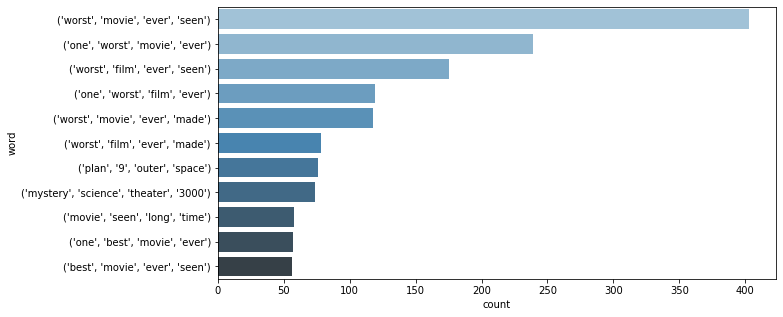

In [22]:
draw_n_gram(texts_to_list, 4)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data['reviews_preprocessed'], data['sentiment'], test_size=0.2, random_state=0)
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(40000,), (10000,), (40000,), (10000,)]

In [24]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=8000
)

word_vectorizer.fit(data['reviews_preprocessed'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

print('Shape of tfidf_train:', tfidf_train.shape)
print('Shape of tfidf_test:', tfidf_test.shape)

Shape of tfidf_train: (40000, 8000)
Shape of tfidf_test: (10000, 8000)


In [25]:
word_vectorizer2 = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=None
)

word_vectorizer2.fit(data['reviews_preprocessed'])

tfidf_train2 = word_vectorizer2.transform(X_train)
tfidf_test2 = word_vectorizer2.transform(X_test)

print('Shape of tfidf_train:', tfidf_train2.shape)
print('Shape of tfidf_test:', tfidf_test2.shape)

Shape of tfidf_train: (40000, 12835757)
Shape of tfidf_test: (10000, 12835757)



Accuracy:  0.884

F1 Score:  0.884


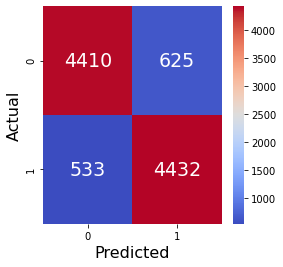

In [26]:
linear_svc = LinearSVC(penalty='l2', dual=False)
linear_svc.fit(tfidf_train, y_train)
metrics(linear_svc, tfidf_test, y_test)


Accuracy:  0.89

F1 Score:  0.892


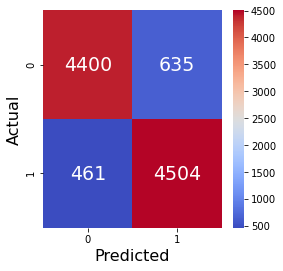

In [27]:
linear_svc = LinearSVC(penalty='l2', dual=False)
linear_svc.fit(tfidf_train2, y_train)
metrics(linear_svc, tfidf_test2, y_test)

### **2) Count Vectorizer-** 


In [28]:
cv=CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                   ngram_range=(1,3),max_features=10000)
cv.fit(data['reviews_preprocessed'])
cv_train = cv.transform(X_train)
cv_test = cv.transform(X_test)
print('Shape of cv_train:', cv_train.shape)
print('Shape of cv_test:', cv_test.shape)

Shape of cv_train: (40000, 10000)
Shape of cv_test: (10000, 10000)


In [29]:
cv4=CountVectorizer(analyzer='word', token_pattern = r'\w{1,}',
                    ngram_range=(1,4),max_features=10000)
cv4.fit(data['reviews_preprocessed'])
cv4_train = cv4.transform(X_train)
cv4_test = cv4.transform(X_test)
print('Shape of cv_train:', cv4_train.shape)
print('Shape of cv_test:', cv4_test.shape)

Shape of cv_train: (40000, 10000)
Shape of cv_test: (10000, 10000)



Accuracy:  0.856

F1 Score:  0.856


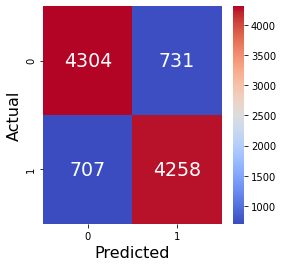

In [30]:
linear_svc = LinearSVC(C=0.5, dual=False, random_state=42)
linear_svc.fit(cv_train, y_train)

metrics(linear_svc, cv_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Accuracy:  0.853

F1 Score:  0.852


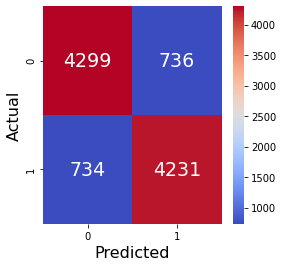

In [31]:
linear_svc = LinearSVC(penalty='l2', dual=False, random_state=42)
linear_svc.fit(cv4_train, y_train)

metrics(linear_svc, cv4_test, y_test)